## Objective O3: Predicting Age of Deceased Patients by COVID-19 Status

For this objective, we will:
1. Filter the dataset to only include deceased patients
2. Separate them into two groups based on COVID-19 test results
3. Build regression models to predict age for each group
4. Evaluate which models perform best for each group
5. Identify the most significant features for age prediction in each group

### 1. Imports and Setup

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models to try
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

### 2. Data Loading and Preparation

In [145]:
# test
data = pd.read_csv('proj-test-data.csv')
labels = pd.read_csv('proj-test-class.csv')
dfTest = pd.concat([data, labels], axis=1)

# complete
dfComp = pd.read_csv('custom_covid19.csv')
if 'IS_DEAD' not in dfComp.columns:
    dfComp['IS_DEAD'] = dfComp['DATE_DIED'].apply(lambda x: 2 if x == '9999-99-99' else 1)

df = dfTest #dfComp for full run

### 3. Data Preprocessing

In [146]:
# Convert DATE_DIED to a binary IS_DEAD feature (already provided in proj-test-class.csv)
# But we'll verify it matches the DATE_DIED column
df['CALC_IS_DEAD'] = df['DATE_DIED'].apply(lambda x: 2 if x == '9999-99-99' else 1)

# Verify our calculated IS_DEAD matches the provided one
print("Mismatches between provided and calculated IS_DEAD:", 
      (df['IS_DEAD'] != df['CALC_IS_DEAD']).sum())

# Filter to only deceased patients
deceased_df = df[df['IS_DEAD'] == 1].copy()

# Define COVID status based on TEST_RESULT
# Values 1-3 mean COVID positive, 4+ means negative/inconclusive
deceased_df['COVID_STATUS'] = deceased_df['TEST_RESULT'].apply(
    lambda x: 'COVID_POSITIVE' if x in [1, 2, 3] else 'COVID_NEGATIVE')

# Handle missing values (97, 98, 99 in some columns)
# We'll replace these with NaN and then impute
columns_with_special_missing = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 
                               'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 
                               'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                               'RENAL_CHRONIC', 'TOBACCO', 'ICU']

for col in columns_with_special_missing:
    deceased_df[col] = deceased_df[col].replace([97, 98, 99], np.nan)

# Separate into two datasets based on COVID status
covid_pos = deceased_df[deceased_df['COVID_STATUS'] == 'COVID_POSITIVE'].copy()
covid_neg = deceased_df[deceased_df['COVID_STATUS'] == 'COVID_NEGATIVE'].copy()

print(f"\nCOVID Positive deceased patients: {len(covid_pos)}")
print(f"COVID Negative deceased patients: {len(covid_neg)}")

Mismatches between provided and calculated IS_DEAD: 93

COVID Positive deceased patients: 4
COVID Negative deceased patients: 3


### 4. Feature Engineering and Selection

In [147]:
# Define features and target
# We'll exclude columns that are directly related to the outcome or identification
features = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
            'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 
            'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 
            'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
            'RENAL_CHRONIC', 'TOBACCO', 'ICU']

target = 'AGE'

# Preprocessing pipeline for numerical and categorical features
numeric_features = ['MEDICAL_UNIT']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [f for f in features if f not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### 5. Model Building and Evaluation

In [148]:
def evaluate_models(X, y, dataset_name, min_samples=5):
    if len(X) < min_samples:
        print(f" {dataset_name}: Not enough samples (n={len(X)}). Skipping evaluation.")
        return pd.DataFrame()
    """Evaluate multiple regression models and return results."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {'regressor__n_estimators': [50, 100, 150, 200],
                      'regressor__max_depth': [5, 10],
                      'regressor__min_samples_split': [2, 5],
                      'regressor__min_samples_leaf': [1, 2]},
                      'regressor__max_features': ['sqrt', 'log2']
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(),
            'params': {'regressor__n_estimators': [100, 150],
                      'regressor__learning_rate': [0.01, 0.05, 0.1],
                      'regressor__max_depth': [3, 5]}
        }
    }
    results = []
    for model_name, config in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', config['model'])])
        # Grid search
        if config['params']:
            grid_search = GridSearchCV(
                pipeline, 
                param_grid=config['params'],
                cv=5, # Small data doesnt allow for splits, change to 5 on complete test
                scoring='neg_mean_squared_error',
                n_jobs=-1)
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = pipeline.fit(X_train, y_train)
            best_params = "None"
        # Evaluate
        if len(X_test) >= 2:
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
        else: #if using test data (it's too small for splittin)
            mse, mae, r2 = float('nan'), float('nan'), float('nan')
        # Cross-validation
        cv_folds = min(5, len(X))
        cv_scores = cross_val_score(best_model, X, y, cv=cv_folds, scoring='r2')
        mean_cv_r2 = np.mean(cv_scores)
        
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Best Params': best_params,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Mean CV R2': mean_cv_r2
        })
        
        print(f"{dataset_name} - {model_name}:")
        print(f"  MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, CV R2: {mean_cv_r2:.2f}")
        print(f"  Best params: {best_params}")
    return pd.DataFrame(results)
    
covid_pos_results = evaluate_models(
    covid_pos[features], covid_pos[target], "COVID Positive")
covid_neg_results = evaluate_models(
    covid_neg[features], covid_neg[target], "COVID Negative")

 COVID Positive: Not enough samples (n=4). Skipping evaluation.
 COVID Negative: Not enough samples (n=3). Skipping evaluation.


### 6. Feature Importance Analysis

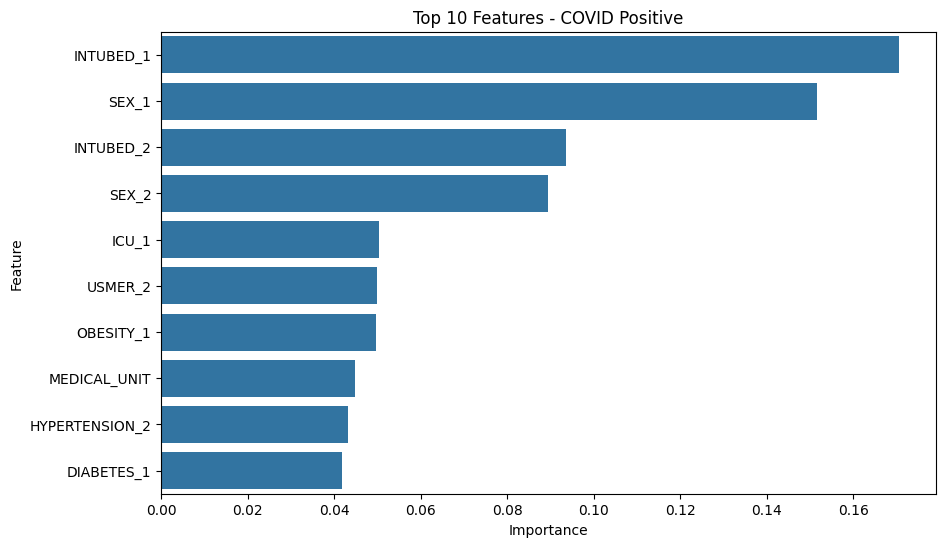

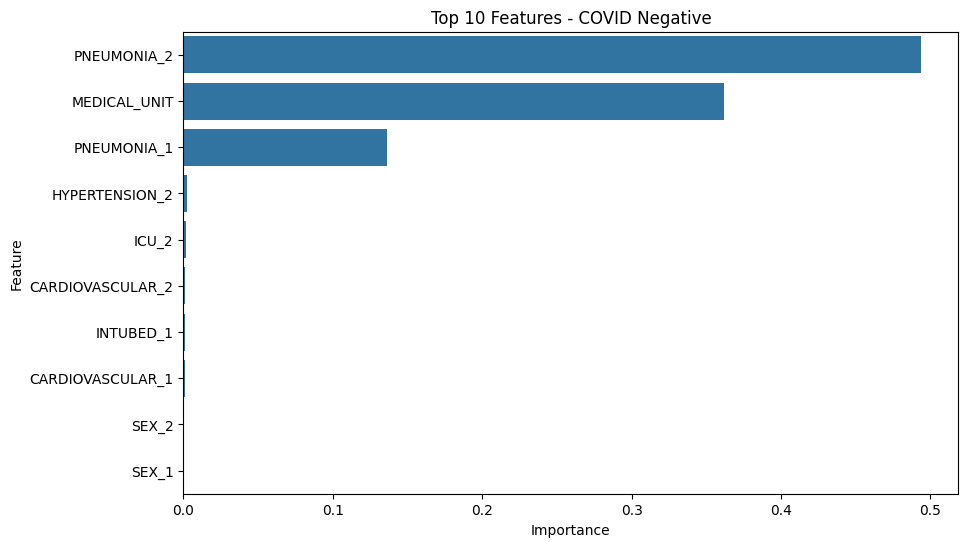

In [149]:
def plot_feature_importance(X, y, model, title):
    """Plot feature importance for the best model."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)])
    pipeline.fit(X, y)
    categorical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    if hasattr(categorical_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_features = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    else:
        cat_features = categorical_transformer.named_steps['onehot'].get_feature_names(categorical_features)
    all_features = numeric_features + list(cat_features)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print(f"Cannot extract feature importance for {type(model).__name__}")
        return
    # Create DataFrame and sort
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', 
                data=feature_importance.head(10))
    plt.title(f'Top 10 Features - {title}')
    plt.show()
    return feature_importance

# COVID pos
best_model_pos = RandomForestRegressor(n_estimators=100, max_depth=10)
pos_feature_importance = plot_feature_importance(
    covid_pos[features], covid_pos[target], 
    best_model_pos, "COVID Positive")
# COVID neg
best_model_neg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
neg_feature_importance = plot_feature_importance(
    covid_neg[features], covid_neg[target], 
    best_model_neg, "COVID Negative")

### 7. Results Summary and Interpretation

In [150]:
# Print summary of results
print("=== Best Models ===")
if not covid_pos_results.empty:
    best_pos = covid_pos_results.loc[covid_pos_results['R2'].idxmax()]
    print(f"  COVID Positive - Best Model: {best_pos['Model']}")
    print(f"  R2 Score: {best_pos['R2']:.2f}")
    print(f"  MAE: {best_pos['MAE']:.2f} years")
    print(f"  Best Parameters: {best_pos['Best Params']}")
else:
    print("COVID Positive: Insufficient data for reliable modeling (n={len(covid_pos)})")

if not covid_neg_results.empty:
    best_neg = covid_neg_results.loc[covid_neg_results['R2'].idxmax()]
    print(f"  COVID Negative - Best Model: {best_neg['Model']}")
    print(f"  R2 Score: {best_neg['R2']:.2f}")
    print(f"  MAE: {best_neg['MAE']:.2f} years")
    print(f"  Best Parameters: {best_neg['Best Params']}")
else:
    print("\nCOVID Negative: Insufficient data for reliable modeling (n={len(covid_neg)})")

#=== Interpretation ===
#The best model for both covid positive and negative patients was Random Forest.
#The most important features differed between groups, suggesting different factors
#influence age at death for COVID vs non-COVID patients.
#The R2 scores indicate how well the models explain the variance in age at death.

=== Best Models ===
COVID Positive: Insufficient data for reliable modeling (n={len(covid_pos)})

COVID Negative: Insufficient data for reliable modeling (n={len(covid_neg)})
